# Testing Notebook

## Imports

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from typing import Dict, Any, Tuple
from datetime import datetime, timedelta

import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rc('figure', figsize=(16, 10))
plt.rc('font', size=14)


In [2]:
import math

import equinox as eqx
import jax
from jax import vmap
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import torch

In [3]:
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [4]:
from typing import Callable, List, Sequence, Union

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


## Functions

In [6]:
def shift_image(
    img: np.ndarray[np.uint8],
    horizontal_shift: int,
    vertical_shift: int,
)->np.ndarray[np.uint8]:
    """
      Function to shift an image by fixed numbers of pixels and fill in with 0.
      
      The image origin in numpy are at the top-left corner so to get a positive
      vertical shift, we need to negate the vertical shift value passed in.
      
      :param img: The input image
      :type img: np.ndarray[np.uint8]
      :param horizontal_shift: the number of pixels to shift horizontally
      :type horizontal_shift: int
      :param vertical_shift: the number of pixels to shift vertically
      :type vertical_shift: int
      :return: The shifted image
      :rtype: np.ndarray[np.uint8]
    """
    # Negate the vertical shift to compensate for the origin at the top-left of image
    vertical_shift = -vertical_shift
    shift_img = np.roll(img, vertical_shift, axis=0)
    shift_img = np.roll(shift_img, horizontal_shift, axis=1)
    if vertical_shift>0:
        shift_img[:vertical_shift, :] = 0
    elif vertical_shift<0:
        shift_img[vertical_shift:, :] = 0
    if horizontal_shift>0:
        shift_img[:, :horizontal_shift] = 0
    elif horizontal_shift<0:
        shift_img[:, horizontal_shift:] = 0
    return shift_img

In [7]:
def sampling_generator(N:int, reverse:bool=False)->list:
    samplings = [False, True] * (N // 2)
    if reverse: 
        return list(reversed(samplings[:N]))
    else: 
        return samplings[:N]

## Load Data

In [8]:
imgs = np.load('/Users/daniel.marthaler/dev/SimVP/data/moving_mnist/mnist_test_seq.npy')
from dataloader_moving_mnist import load_data

In [9]:
class Lambda(eqx.Module):
    fn: Callable

    def __call__(self , x, *, key=None):
        return self.fn(x)

In [10]:
from einops import rearrange
from functools import partial

#x = jnp.arange(5 * 8 * 8 * 3).reshape(5, 8, 8, 3)
#pixel_shuffle(x) = print(x.shape) # (5, 4, 4, 12)
# pixel_unshuffle(pixel_shuffle(x)) = print(x.shape) # (5, 8, 8, 3)

class PixelShuffle(eqx.Module):
    scale_factor: int
    layer: partial

    def __init__(self, scale_factor: int)->None:
        self.scale_factor = scale_factor
        self.layer = partial(
            rearrange,
            pattern='... (c b1 b2) h w -> ... c (h b1) (w b2)',
            b1=self.scale_factor,
            b2=self.scale_factor
        )

    def __call__(self, x: Array, key: jax.random.PRNGKey=None) -> Array:
        return self.layer(x)


In [11]:
class BasicConv2d(eqx.Module):
    act_norm: bool
    conv: list
    norm: eqx.nn.GroupNorm
    act: jax.nn.silu

    def __init__(
        self,
        key: jax.random.PRNGKey,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Sequence[int]]=3,
        stride: Union[int, Sequence[int]]=1,
        padding: Union[str, int, Sequence[int]]=0,
        dilation: Union[str, int, Sequence[int]]=1,
        upsampling: bool=False,
        act_norm: bool=False,
    )->None:
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if upsampling is True:
            self.conv = eqx.nn.Sequential([*[
                eqx.nn.Conv2d(in_channels, out_channels*4, kernel_size=kernel_size,
                          stride=stride, padding=padding, dilation=dilation, key=key),
                PixelShuffle(2)
            ]])
        else:
            self.conv = eqx.nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation,key=key)
            
        self.norm = eqx.nn.GroupNorm(2, out_channels)
        self.act = jax.nn.silu
        
    def __call__(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


In [12]:
class ConvSC(eqx.Module):
    conv: eqx.nn.Conv
    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_in: int,
        C_out: int,
        kernel_size: int=3,
        downsampling=False,
        upsampling=False,
        act_norm: bool=True,
    )->None:
        super(ConvSC, self).__init__()

        stride = 2 if downsampling is True else 1
        padding = (kernel_size - stride + 1) // 2

        self.conv = BasicConv2d(
            key,
            C_in, 
            C_out, 
            kernel_size=kernel_size, 
            stride=stride,
            upsampling=upsampling,
            padding=padding,
            act_norm=act_norm,
        )

    def __call__(self, x):
        y = self.conv(x)
        return y

In [13]:
class Encoder(eqx.Module):
    """3D Encoder for SimVP"""
    enc: list

    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_in: int,
        C_hid: int, 
        N_S: int, 
        spatio_kernel: int,
    )->None:
        super(Encoder, self).__init__()
        samplings = sampling_generator(N_S)
        keys = jax.random.split(key, N_S)
        self.enc = eqx.nn.Sequential([
              ConvSC(keys[0], C_in, C_hid, spatio_kernel, downsampling=samplings[0],),
            *[ConvSC(k,C_hid, C_hid, spatio_kernel, downsampling=s,) for k,s in zip(keys[1:],samplings[1:])]
        ]
        )
        
    def __call__(self, x: Array)->Array:
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)
        return latent, enc1

In [14]:
class Decoder(eqx.Module):
    """3D Decoder for SimVP"""
    readout: eqx.nn.Conv2d
    dec: list

    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_hid: int,
        C_out: int, 
        N_S: int,
        spatio_kernel: int,
    )->None:
        super(Decoder, self).__init__()
        samplings = sampling_generator(N_S, reverse=True)
        keys = jax.random.split(key, N_S+1)
        self.dec = eqx.nn.Sequential([
            *[ConvSC(k, C_hid, C_hid, spatio_kernel, upsampling=s,) for k,s in zip(keys[:-2],samplings[:-1])],
              ConvSC(keys[-2],C_hid, C_hid, spatio_kernel, upsampling=samplings[-1],)
        ])

        self.readout = eqx.nn.Conv2d(C_hid, C_out, 1, key=keys[-1],)

    def __call__(self, hid, enc1=None):
        for i in range(0, len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](hid+enc1)
        return self.readout(Y)

In [15]:
class AttentionModule(eqx.Module):
    """Large Kernel Attention for SimVP"""
    conv0: eqx.nn.Conv2d
    conv_spatial: eqx.nn.Conv2d
    conv1: eqx.nn.Conv2d

    def __init__(
        self,
        key: jax.random.PRNGKey, 
        dim: int,
        kernel_size: int,
        dilation: int=3,
    )->None:
        super().__init__()
        d_k = 2 * dilation - 1
        d_p = (d_k - 1) // 2
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1)
        dd_p = (dilation * (dd_k - 1) // 2)

        self.conv0 = eqx.nn.Conv2d(dim, dim, d_k, padding=d_p, groups=dim)
        self.conv_spatial = eqx.nn.Conv2d(
            dim, dim, dd_k, stride=1, padding=dd_p, groups=dim, dilation=dilation
        )
        self.conv1 = eqx.nn.Conv2d(dim, 2*dim, 1)

    def __call__(self, x: Array)->Array:
        attn = self.conv0(x)           # depth-wise conv
        attn = self.conv_spatial(attn) # depth-wise dilation convolution
        
        f_g = self.conv1(attn)
        split_dim = f_g.shape[1] // 2
        f_x, g_x = jnp.split(f_g, split_dim, axis=1)
        return jax.nn.sigmoid(g_x) * f_x

In [16]:
class SpatialAttention(eqx.Module):
    """A Spatial Attention block for SimVP"""
    proj1: eqx.nn.Conv2d
    activation: jax.nn.gelu
    spatial_gating_unit: AttentionModule
    proj2: eqx.nn.Conv2d
    attn_shortcut: bool

    def __init__(
        self,
        d_model,
        kernel_size=21,
        attn_shortcut=True
    ):
        super().__init__()

        self.proj_1 = eqx.nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.activation = jax.nn.gelu                            # GELU
        self.spatial_gating_unit = AttentionModule(d_model, kernel_size)
        self.proj_2 = eqx.nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.attn_shortcut = attn_shortcut

    def __call__(self, x:Array)->Array:
        if self.attn_shortcut:
            shortcut = x.copy()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        if self.attn_shortcut:
            x = x + shortcut
        return x

In [25]:
class GroupConv2d(eqx.Module):
    act_norm: bool
    conv: eqx.nn.Conv2d
    norm: eqx.nn.GroupNorm
    act: jax.nn.leaky_relu

    def __init__(
        self,
        key: jax.random.PRNGKey,
        in_channels: int,
        out_channels: int,
        kernel_size: int=3,
        stride: int=1,
        padding: int=0,
        groups: int=1,
        act_norm: bool=False,
    ):
        super(GroupConv2d, self).__init__()
        self.act_norm=act_norm
        if in_channels % groups != 0:
            groups=1
        self.conv = eqx.nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=groups, key=key)
        self.norm = eqx.nn.GroupNorm(groups,out_channels)
        self.act = jax.nn.leaky_relu

    def __call__(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y

In [26]:
class gInception_ST(eqx.Module):
    """A IncepU block for SimVP"""
    conv1: eqx.nn.Conv2d
    layers: eqx.nn.Sequential

    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_in: int, 
        C_hid: int, 
        C_out: int, 
        incep_ker: List[int] = [3,5,7,11], 
        groups:int = 8
    ):        
        super(gInception_ST, self).__init__()
        keys = jax.random.split(key, 1+len(incep_ker))
        self.conv1 = eqx.nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0,key=keys[0])

        layers = []
        for i, ker in enumerate(incep_ker):
            layers.append(
                GroupConv2d(
                    keys[1+i],
                    C_hid, 
                    C_out, 
                    kernel_size=ker, 
                    stride=1,
                    padding=ker//2, 
                    groups=groups, 
                    act_norm=True
            )
        )
        self.layers = eqx.nn.Sequential(layers)

    def __call__(self, x: Array)->Array:
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

In [31]:
class MidIncepNet(eqx.Module):
    """The hidden Translator of IncepNet for SimVPv1"""
    N2: int
    enc: eqx.nn.Sequential
    dec: eqx.nn.Sequential

    def __init__(
        self,
        key: jax.random.PRNGKey,
        channel_in: int, 
        channel_hid: int, 
        N2: int, 
        incep_ker: List[int]=[3,5,7,11], 
        groups: int=8, 
        **kwargs
    ):
        super(MidIncepNet, self).__init__()
        assert N2 >= 2 and len(incep_ker) > 1, "Incorrect N2 and incep_ker in MidInceptNet"
        self.N2 = N2
        keys = jax.random.split(key, 2*N2)
        enc_layers = [
            gInception_ST(
                keys[0],
                channel_in, 
                channel_hid//2, 
                channel_hid, 
                incep_ker= incep_ker, 
                groups=groups
            )
        ]
        for i in range(1,N2-1):
            enc_layers.append(
                gInception_ST(
                    keys[i],
                    channel_hid, 
                    channel_hid//2, 
                    channel_hid,
                    incep_ker=incep_ker, 
                    groups=groups
                )
            )
        enc_layers.append(
                gInception_ST(
                    keys[N2-1],
                    channel_hid, 
                    channel_hid//2, 
                    channel_hid,
                    incep_ker=incep_ker,
                    groups=groups
                )
        )
        
        dec_layers = [
                gInception_ST(
                    keys[N2],
                    channel_hid, 
                    channel_hid//2, 
                    channel_hid,
                    incep_ker=incep_ker, 
                    groups=groups
                )
        ]
        for i in range(1,N2-1):
            dec_layers.append(
                gInception_ST(
                    keys[N2+i],
                    2*channel_hid, 
                    channel_hid//2, 
                    channel_hid,
                    incep_ker=incep_ker, 
                    groups=groups
                )
            )
        dec_layers.append(
                gInception_ST(
                    keys[-1],
                    2*channel_hid, 
                    channel_hid//2, 
                    channel_in,
                    incep_ker=incep_ker,
                    groups=groups
                )
        )

        self.enc = eqx.nn.Sequential(enc_layers)
        self.dec = eqx.nn.Sequential(dec_layers)

    def __call__(self, x: Array)->Array:
        T, C, H, W = x.shape
        x = x.reshape(T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N2):
            z = self.enc[i](z)
            if i < self.N2-1:
                skips.append(z)
        # decoder
        z = self.dec[0](z)
        for i in range(1,self.N2):
            z = self.dec[i](jnp.concatenate([z, skips[-i]], axis=1) )

        y = z.reshape(T, C, H, W)
        return y

In [32]:
class SimVP(eqx.Module):
    enc: Encoder
    hid: MidIncepNet
    dec: Decoder

    def __init__(
        self,
        key: jax.random.PRNGKey,
        in_shape: Tuple,
        hid_S: int=16,
        hid_T: int=256,
        N_S: int=4,
        N_T: int=4,
        model_type: str='gSTA',
        spatio_kernel_enc: int=3,
        spatio_kernel_dec: int=3,
        **kwargs,
    )->None:
        super(SimVP, self).__init__()
        T, C, H, W = in_shape
        H, W = int(H / 2**(N_S/2)), int(W / 2**(N_S/2))  # downsample 1 / 2**(N_S/2)
        keys = jax.random.split(key, 3)
        self.enc = Encoder(keys[0], C, hid_S, N_S, spatio_kernel_enc,)
        self.dec = Decoder(keys[2], hid_S, C, N_S, spatio_kernel_dec,)
        self.hid = MidIncepNet(keys[1], T*hid_S, hid_T, N_T)


    def __call__(self, x_raw: Array, **kwargs)->Array:
        B, T, C, H, W = x_raw.shape
        x = x_raw.reshape(B*T, C, H, W)
        embed, skip = vmap(self.enc)(x)
        
        _, C_, H_, W_ = embed.shape
        z = embed.reshape(B, T, C_, H_, W_)
        hid = vmap(self.hid)(z)
        hid = hid.reshape(B*T, C_, H_, W_)
        
        Y = vmap(self.dec)(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

## Parameters

In [21]:
# model parameters
in_shape=[10, 1, 64, 64]
spatio_kernel_enc = 3
spatio_kernel_dec = 3
model_type = 'gSTA'
hid_S = 64
hid_T = 512
N_T = 8
N_S = 2

# training
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
TOTAL_STEPS = 1500
TOTAL_EPOCH = 5
PRINT_EVERY = 30
SEED = 42
val_batch_size=16
num_workers=8
drop_path = 0
sched = 'onecycle'

In [22]:
key = jax.random.PRNGKey(SEED)

In [23]:
train_loader, vali_loader, test_loader, data_mean, data_std = load_data(
    BATCH_SIZE,
    BATCH_SIZE,
    '/Users/daniel.marthaler/dev/SimVP/data',
    num_workers
)
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.numpy()
y_batch = y_batch.numpy()

## Model

In [33]:
model = SimVP(
    key,
    tuple(in_shape),
    hid_S,
    hid_T,
    N_S,
    N_T,
    spatio_kernel_enc=spatio_kernel_enc,
    spatio_kernel_dec=spatio_kernel_dec
)

In [34]:
y_pred = model(x_batch)

ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 512 // 1 != 1024.

In [60]:
def compute_loss(model, x, y):
    pred_y = model(x)
    # Trains with respect to huber loss
    #return optax.losses.huber_loss(pred_y, y).sum()
    return optax.losses.l2_loss(pred_y, y).sum()

loss = eqx.filter_jit(compute_loss)

In [61]:
def evaluate(model: SimVP, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    for x, y in testloader:
        x = x.numpy().astype(float)
        #y = y.numpy().astype(float)
        # Note that all the JAX operations happen inside `loss` ,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, x)
    return avg_loss / len(testloader)

In [62]:
cosine_decay_scheduler = optax.cosine_decay_schedule(LEARNING_RATE, decay_steps=TOTAL_STEPS, alpha=0.95)

In [63]:
optim = optax.adamw(learning_rate=cosine_decay_scheduler)

In [64]:
def train(
    model: SimVP,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
    first_call: bool=True,
    opt_state_saved: PyTree=None,
) -> SimVP:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    if first_call:
        opt_state = optim.init(eqx.filter(model, eqx.is_array))
    else:
        opt_state = opt_state_saved

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: SimVP,
        opt_state: PyTree,
        x: Float[Array, "batch 10 1 64 64"],
        y: Float[Array, "batch 10 1 64 64"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy().astype(float)
        y = y.numpy().astype(float)
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss = evaluate(model, testloader)
            print(
                f"{step}, train_loss={train_loss.item()}, test_loss={test_loss.item()}"
            )
    return model, opt_state

In [65]:
model, opt_state_saved = train(
    model,
    train_loader,
    test_loader,
    optim,
    TOTAL_STEPS,
    PRINT_EVERY,
    first_call=True,
    opt_state_saved=None,
)
y_pred = model(x_batch)
models.append(model)
states.append(opt_state_saved)
j=2; k=5; l=0
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(y_pred[j,k,l,:,:])
ax2.imshow(y_batch[j,k,l,:,:])
plt.show()

models = [model]
states = [opt_state_saved]
for epoch in TOTAL_EPOCH:
    print(epoch)
    model, opt_state_saved = train(
        model,
        train_loader,
        test_loader,
        optim,
        TOTAL_STEPS,
        PRINT_EVERY,
        first_call=False,
        opt_state_saved=opt_state_saved,
    )
    y_pred = model(x_batch)
    models.append(model)
    states.append(opt_state_saved)
    j=2; k=5; l=0
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    ax1.imshow(y_pred[j,k,l,:,:])
    ax2.imshow(y_batch[j,k,l,:,:])
    plt.show()

ValueError: ('Input to `Conv` needs to have rank 3,', ' but input has shape (64, 640, 32, 32).')

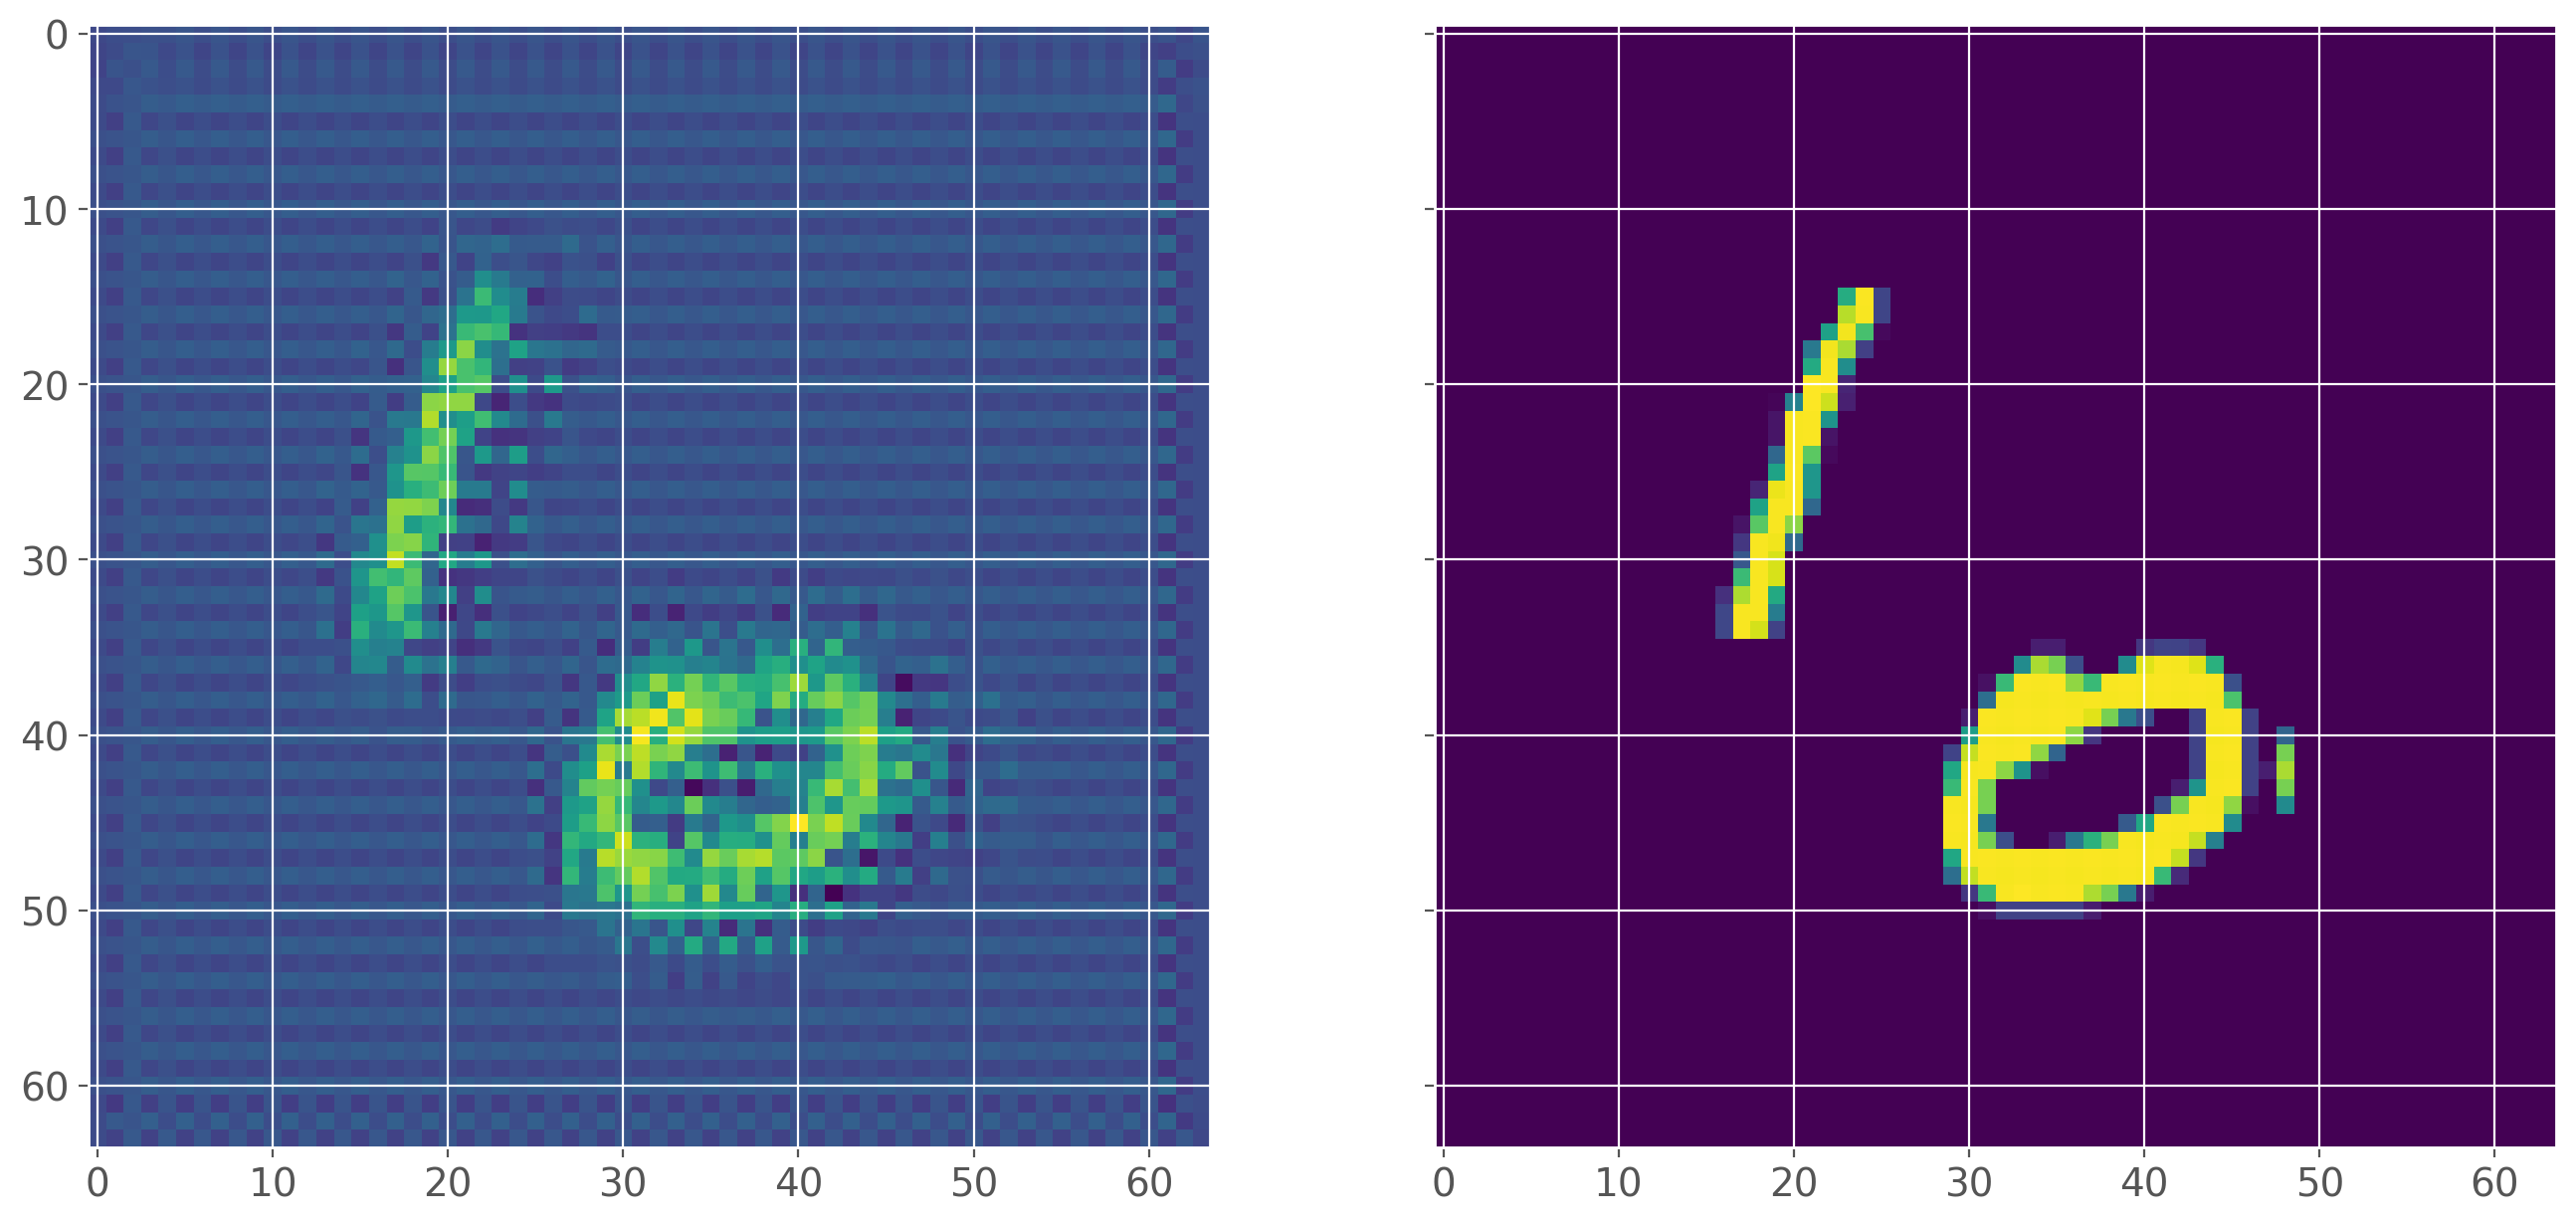

In [25]:
y_pred = model(x_batch)
#models.append(model)
#states.append(opt_state_saved)
j=2; k=5; l=0
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(y_pred[j,k,l,:,:])
ax2.imshow(x_batch[j,k,l,:,:])
plt.show()

In [28]:
x_batch.shape


(64, 10, 1, 64, 64)

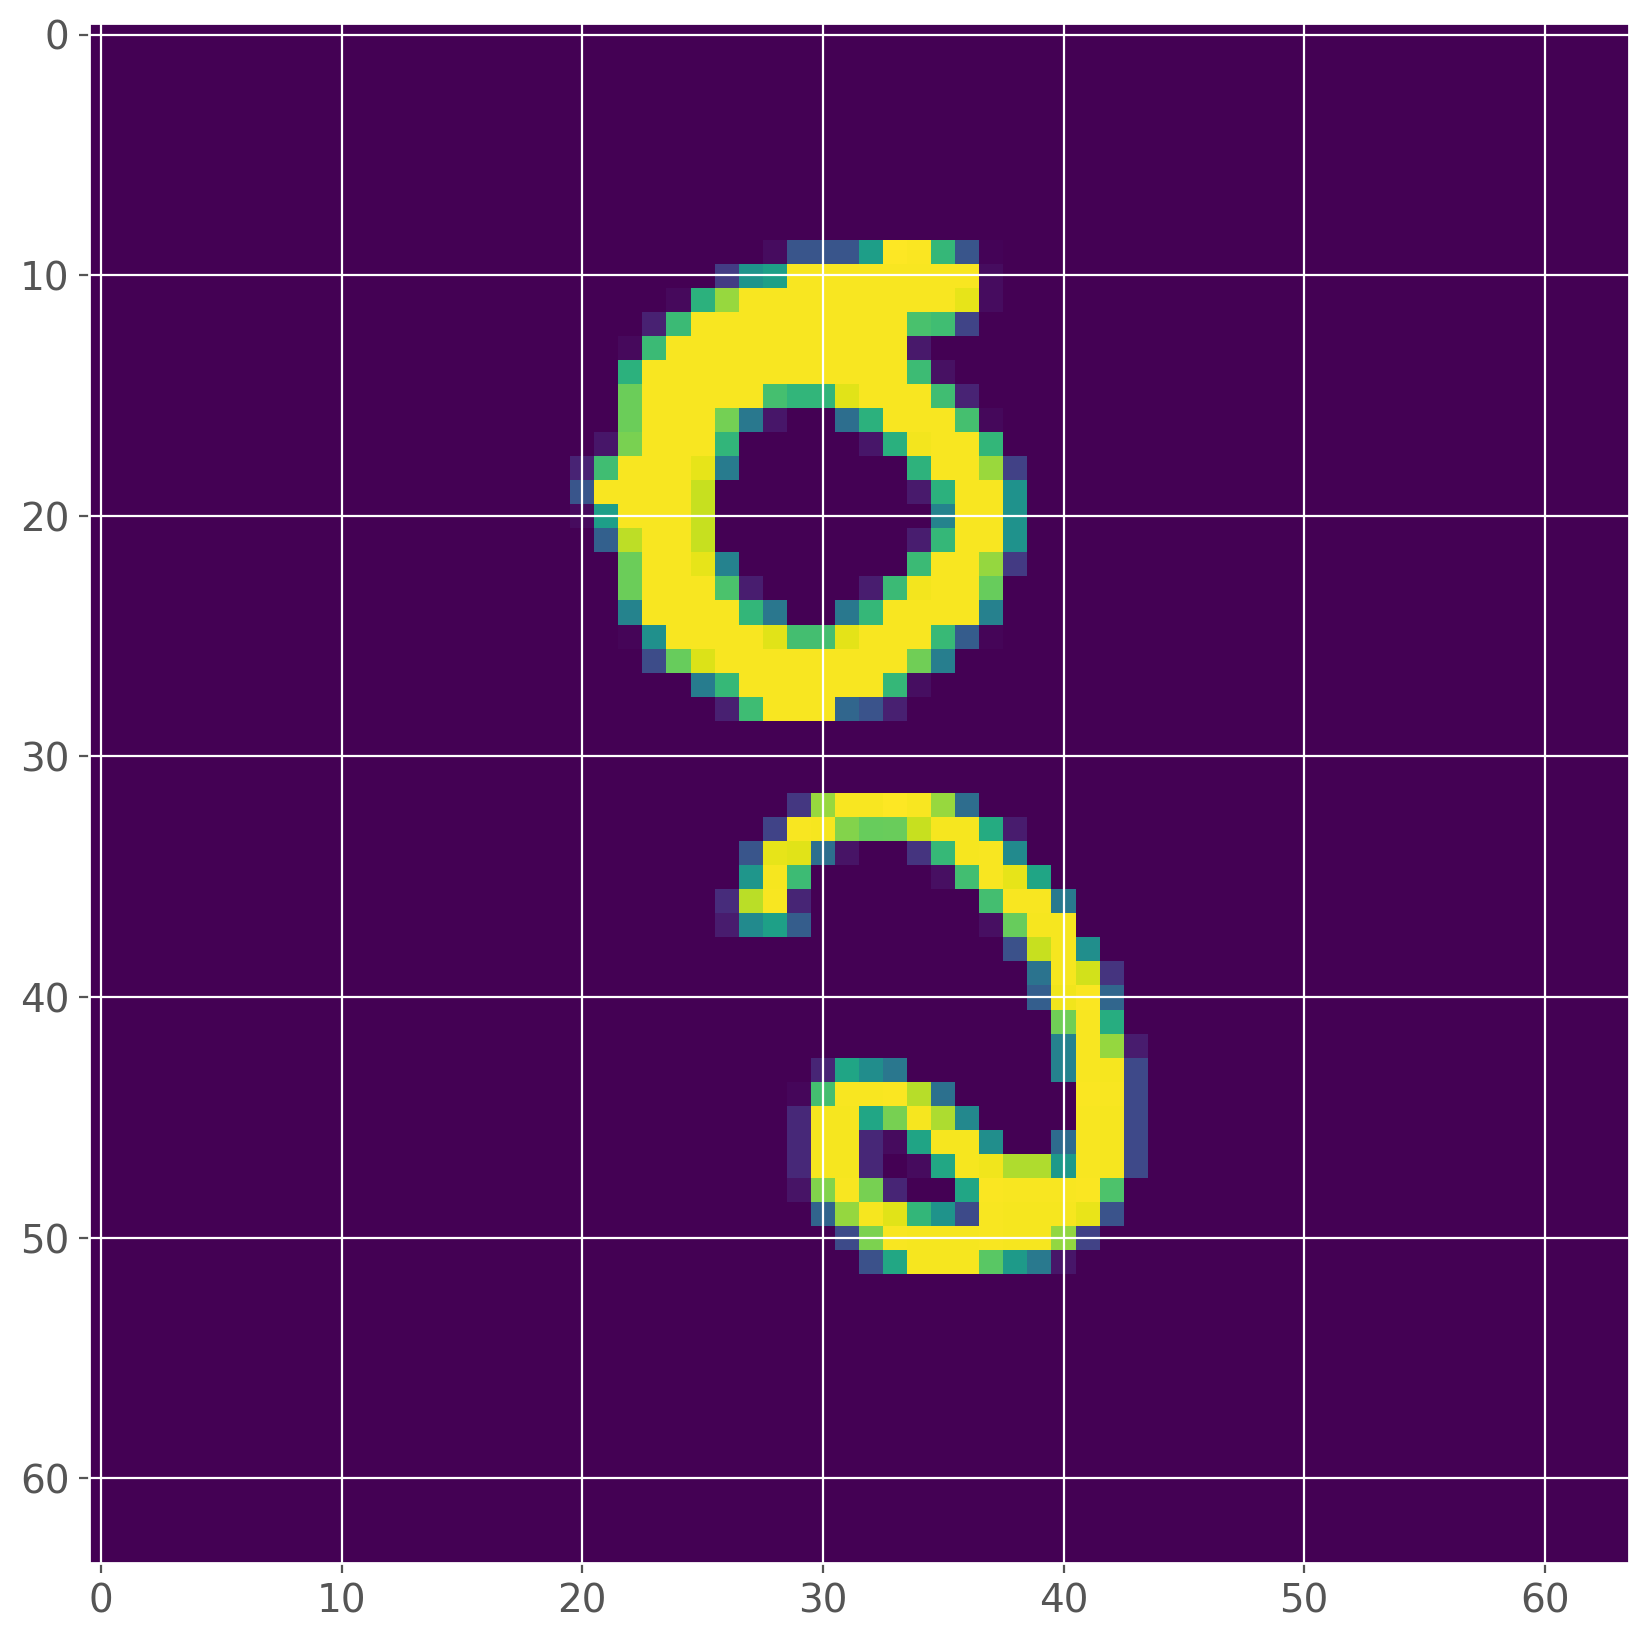

In [30]:
j=2; k=5; l=0
plt.imshow(x_batch[j,k,l,:,:])